In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import datetime
import os

In [2]:
df_price = pd.read_csv(os.path.join('003490.KS.csv'), encoding='utf-8')
df_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-12-10,25800.400391,26891.300781,25800.400391,26891.300781,26690.619141,680382.0
1,2015-12-11,26986.099609,26986.099609,26464.400391,26511.800781,26313.951172,264344.0
2,2015-12-14,26511.800781,26511.800781,25847.900391,25942.699219,25749.097656,234765.0
3,2015-12-15,25847.900391,26085.000000,25705.599609,25800.400391,25607.859375,239741.0
4,2015-12-16,26132.400391,26274.699219,25942.699219,25942.699219,25749.097656,194708.0


In [3]:
df_price = df_price.dropna()

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
df_scaled = scaler.fit_transform(df_price[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

print(df_scaled)

          Open      High       Low     Close    Volume
0     0.476578  0.442015  0.508822  0.528481  0.009132
1     0.522895  0.445599  0.534810  0.513392  0.003548
2     0.504367  0.427667  0.510681  0.490763  0.003151
3     0.478434  0.411531  0.505112  0.485105  0.003218
4     0.489547  0.418703  0.514391  0.490763  0.002613
...        ...       ...       ...       ...       ...
1216  0.486328  0.432892  0.518591  0.499006  0.038380
1217  0.488281  0.412098  0.485323  0.485089  0.031483
1218  0.476562  0.449905  0.499022  0.520875  0.072396
1219  0.531250  0.480151  0.536204  0.562624  0.102215
1220  0.558594  0.497164  0.571429  0.572565  0.060429

[1221 rows x 5 columns]


In [5]:
train = df_scaled[:-300]
test = df_scaled[-300:]

In [6]:
def make_dataset(data, label, window_size=30):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [7]:
feature_cols = ['Open', 'High', 'Low', 'Volume']
label_cols = ['Close']

train_feature = train[feature_cols]
train_label = train[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, 20)

from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

x_train.shape, x_valid.shape

test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape

((280, 20, 4), (280, 1))

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import LSTM

model = Sequential()
model.add(GRU(16, input_shape=(20,4), activation='relu', return_sequences=True))
model.add(GRU(50, return_sequences=False))
model.add(Dense(1))

In [11]:
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=6) #overfitting 방지
filename = os.path.join('tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                    epochs=20, 
                    batch_size=16,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/20
45/45 [==============================] - ETA: 0s - loss: 0.0017
Epoch 00001: val_loss improved from inf to 0.00080, saving model to tmp_checkpoint.h5
45/45 [==============================] - 1s 17ms/step - loss: 0.0017 - val_loss: 7.9955e-04
Epoch 2/20
40/45 [=========================>....] - ETA: 0s - loss: 0.0011
Epoch 00002: val_loss did not improve from 0.00080
45/45 [==============================] - 0s 9ms/step - loss: 0.0011 - val_loss: 9.7066e-04
Epoch 3/20
40/45 [=========================>....] - ETA: 0s - loss: 0.0012
Epoch 00003: val_loss improved from 0.00080 to 0.00079, saving model to tmp_checkpoint.h5
45/45 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 7.9057e-04
Epoch 4/20
45/45 [==============================] - ETA: 0s - loss: 0.0013
Epoch 00004: val_loss did not improve from 0.00079
45/45 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 8.2898e-04
Epoch 5/20
44/45 [============================>.] - ETA: 

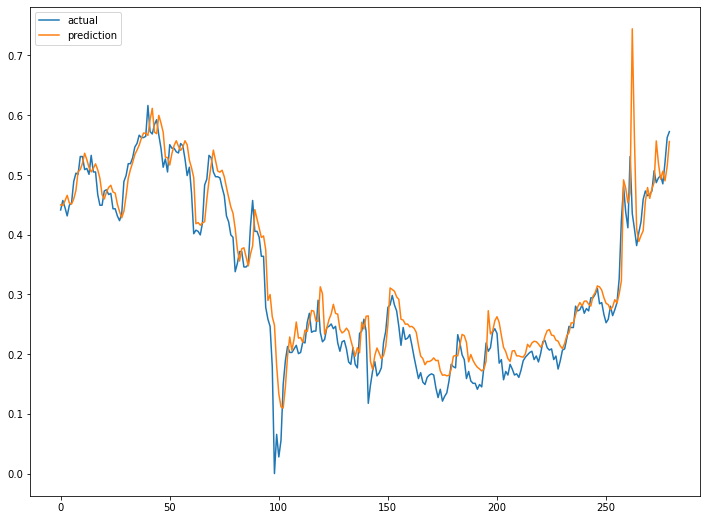

In [12]:
model.load_weights(filename)
pred = model.predict(test_feature)

plt.figure(figsize=(12, 9))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()